# Introduction to Machine Learning in Python - Experimentation

Having two comparable models, we want to answer simple question - **is model A or B doing better?** It turns out that answering this simple question is quite complex. 

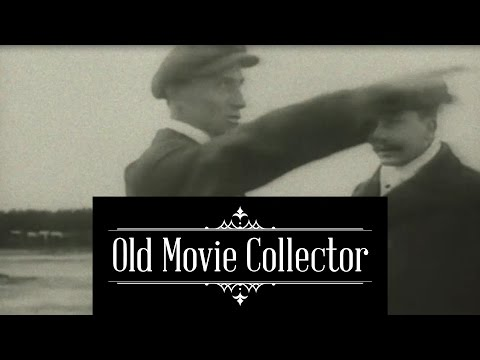

In [1]:
# youtube
from IPython.display import YouTubeVideo
YouTubeVideo('-kjRL-Q-KBc', start=55, width=600, height=400)

# Clinical Trials

<a href="https://www.bbvaopenmind.com/en/science/leading-figures/james-lind-and-scurvy-the-first-clinical-trial-in-history/"><img src="https://ichef.bbci.co.uk/news/660/cpsprodpb/D597/production/_91097645_jameslind.jpg" /></a>

# Online Controlled Experiments

Online controlled experiments, A/B tests or simply experiments, are widely used by data-driven companies to evaluate the impact of change and are the only data-driven approach to prove causality.

<img src="./imlp3_files/oce.png" width="600" />

Sample of real users, not WEIRD (Western, Educated, Industrialized, Rich, and Democratic).

Experiment execution:

1. Users are randomly assigned to one of the two variants: Control (A) or Treatment (B).
2. Control is usually existing system while Treatment is the system with the new feature $X$ to test.
3. Users' interactions with the system are recorded.
4. We calculate metrics from recorded data.

If the experiment has been designed and executed correctly, the only thing consistently different between the two variants is feature $X$. All external factors are eliminated by being evenly distributed among Control and Treatment. We can hypothesize that any difference in metrics between the two variants can be attributed to either feature $X$ or to due to a change resulted from random assigment of users to variants. The later is ruled out (probalistically) using statistical tests. This establishes a causal relationship between the feature change $X$ and changes in user behavior. In S. Gupta, R. Kohavi, et al. [Top Challenges from the first Practical Online Controlled
Experiments Summit](https://exp-platform.com/Documents/2019-FirstPracticalOnlineControlledExperimentsSummit_SIGKDDExplorations.pdf)

1. [Statistics at Heart](#intuition)
1. [Null Hypothesis Significance Testing and Sampling Distributions](#null)
1. [Bayes Analysis](#bayes)
1. [Decision Rules](#decision)
1. [Probabilistic Results](#pbb)
1. [Rules of Thumb](#rules)
1. [Top Challenges](#not)
1. [Resources](#resources)

# Why A/B Tests?

Because assessing the value of novel ideas is hard.

## Correlation and Causation

Bloodletting effect of having calming effects on patients let doctors practice it for 2000 years.
<a href="https://en.wikipedia.org/wiki/Bloodletting"><img src="https://upload.wikimedia.org/wikipedia/commons/b/bc/BloodlettingPhoto.jpg" width="300" /></a>

## Novelty

1. [Semmelweis Reflex](https://en.wikipedia.org/wiki/Semmelweis_reflex).
2. It is hard to subject your idea to the metric and receive negative feedback.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Ignaz_Semmelweis_1860.jpg/440px-Ignaz_Semmelweis_1860.jpg" width="300" />

## Learnings

1. *To have a great idea, have a lot of them.* (Thomas Edison)
1. *If you have to kiss a lot of frogs, to find a prince, find more frogs and kiss them faster and faster.* (Mike Moran, Do it Wrong Quickly)

<table><tr>
    <td><a href="https://en.wikipedia.org/wiki/Thomas_Edison"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Thomas_Edison2.jpg/440px-Thomas_Edison2.jpg"/ width="300"></a></td>
        <td><a href="https://www.amazon.com/Do-Wrong-Quickly-Changes-Marketing/dp/0132255960"><img src="https://images-na.ssl-images-amazon.com/images/I/51WczH0uCPL._SX375_BO1,204,203,200_.jpg" width="300"/></a></td>
</tr></table>

## HiPPO

![hippo](./imlp3_files/hippo.jpg)

*If we have data, let's look at data. If all we have are opinions, let's go with mine.* (Jim Barksdale - former CEO of Netscape)

In [3]:
# import some basic libraries to do analysis and ML
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.stats as st
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Visualization details
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

<a id="intuition"></a>
# Statistics at Heart

Experiments and their evaluation is a work with uncertainity that requires some mathematics so we can talk about it precisly :)

Let's use an experiment measuring click through rate CTR (defined as clicks/views) of some button on some website. Control variant A (current default) uses green color, threatment variant B (challenger) uses red button. We ran randomized experiment on users of our website with following results

## What Variant to Choose?

| Variant | Views | Clicks | CTR | Relative Difference |
| ------- | -----:| ------:| ---:| -------------------:|
| A       | 1,000 | 100    | 10% | ---                 |
| B       | 1,000 | 110    | 11% | +10%                |

Before we decided to run such test, we agreed on stopping it when both variants reach 1,000 views. We can't run this experiment any longer because it takes too long to get that many views. Our question to answer is if variant B is better than variant A. This is all information we have and we have to determine if we trust that B is better than A.

We work with a sample of 1,000 views per variant and want to reason about whole populations of views (users, ...) in A and B. CTR of 10% (11%) are the most likely estimates of population CTR given the data we have. But the real situation is little bit more complicated. True population CTRs can be anywhere around our estimates.

Probability distribution of true population CTRs.

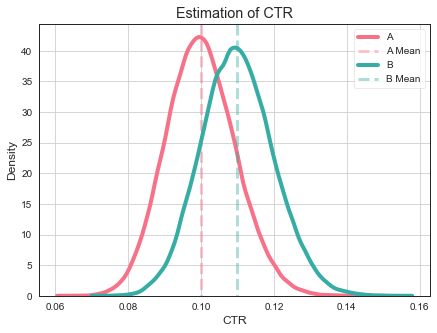

In [60]:
# estimations

N = 100000
a = st.beta(100, 1000 - 100)
b = st.beta(110, 1000 - 110)
a_rvs = a.rvs(N)
b_rvs = b.rvs(N)

fig, ax = plt.subplots(figsize=(7, 5))
cs = sns.color_palette("husl", 2)
sns.kdeplot(a_rvs, bw='silverman', legend=True, ax=ax, label='A', linewidth=4, color=cs[0]);
ax.axvline(np.mean(a_rvs), 1., 0., c=cs[0], linestyle='dashed', alpha=.4, label='A Mean', linewidth=3)
sns.kdeplot(b_rvs, bw='silverman', legend=True, ax=ax, label='B', linewidth=4, color=cs[1]);
ax.axvline(np.mean(b_rvs), 1., 0., c=cs[1], linestyle='dashed', alpha=.4, label='B Mean', linewidth=3)
ax.set_title('Estimation of CTR')
ax.set_xlabel('CTR');
ax.set_ylabel('Density')
ax.legend()
ax.grid();

It can easily happen that true CTR of variant B is below true CTR of variant A despite measuring otherwise.

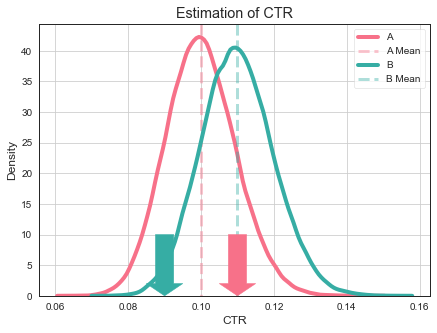

In [62]:
# where could true population means be?

fig, ax = plt.subplots(figsize=(7, 5))
cs = sns.color_palette("husl", 2)
sns.kdeplot(a_rvs, bw='silverman', legend=True, ax=ax, label='A', linewidth=4, color=cs[0]);
ax.axvline(np.mean(a_rvs), 1., 0., c=cs[0], linestyle='dashed', alpha=.4, label='A Mean', linewidth=3)
sns.kdeplot(b_rvs, bw='silverman', legend=True, ax=ax, label='B', linewidth=4, color=cs[1]);
ax.axvline(np.mean(b_rvs), 1., 0., c=cs[1], linestyle='dashed', alpha=.4, label='B Mean', linewidth=3)
ax.set_title('Estimation of CTR')
ax.set_xlabel('CTR');
ax.set_ylabel('Density')
ax.legend()
ax.grid();
ax.arrow(0.11, 10, 0, -10, length_includes_head=True, width=.005, head_length=2, head_width=.01, overhang=0, color=cs[0], shape='full', zorder=10);
ax.arrow(0.09, 10, 0, -10, length_includes_head=True, width=.005, head_length=2, head_width=.01, overhang=0, color=cs[1], shape='full', zorder=10);

What to do, do having more data help in this case? Yes, having more data makes our estimate more accurate. So it is very unlikely that CTR of variant A to be close to 0.11.

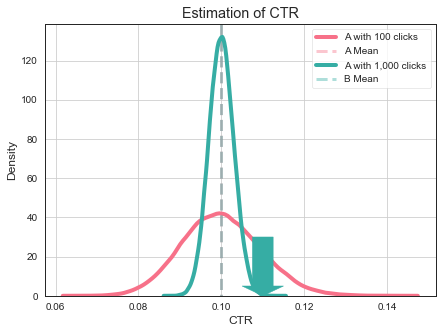

In [66]:
# effect of more samples in the experiment
N = 100000
a = st.beta(100, 1000 - 100)
b = st.beta(1000, 10000 - 1000)
a_rvs = a.rvs(N)
b_rvs = b.rvs(N)

fig, ax = plt.subplots(figsize=(7, 5))
cs = sns.color_palette("husl", 2)
sns.kdeplot(a_rvs, bw='silverman', legend=True, ax=ax, label='A with 100 clicks', linewidth=4, color=cs[0]);
ax.axvline(np.mean(a_rvs), 1., 0., c=cs[0], linestyle='dashed', alpha=.4, label='A Mean', linewidth=3)
sns.kdeplot(b_rvs, bw='silverman', legend=True, ax=ax, label='A with 1,000 clicks', linewidth=4, color=cs[1]);
ax.axvline(np.mean(b_rvs), 1., 0., c=cs[1], linestyle='dashed', alpha=.4, label='B Mean', linewidth=3)
ax.set_title('Estimation of CTR')
ax.set_xlabel('CTR');
ax.set_ylabel('Density')
ax.legend()
ax.grid();
ax.arrow(0.11, 30, 0, -30, length_includes_head=True, width=.005, head_length=5, head_width=.01, overhang=0, color=cs[1], shape='full', zorder=10);

<a id="null"></a>
# Null Hypothesis Significance Testing

*Null hypothesis significance testing* is common approach to deal with this uncertainties.

*NHST* decides if a null hypothesis can be rejected given obtained data.

Examples of null hypothesis:

1. A coin is fair. Meaning we can expect equal number of heads and tails from $N$ tosses of the coin.
1. CTRs of variant A and B are equal.

## Sampling Distribution

Let's assume our null hypothesis is valid. If we ran the same experiment many times, we get many point estimates $\hat{\mu}$ of population metric mean $\mu$ (eg. CTR). These estimates are normally distributed because of a Central limit theorem and because we assume the null hypothesis is true they are centered around population $\mu$. This distribution is called *sampling distribution* and it is **only imaginative**, we do not construct it from the data, it comes from the assumption about the null hypothesis. 


We usually run only 1 experiment giving us point estimate $\hat{\mu}$ of population mean $\mu$. If $\hat{\mu}$ lies out of where eg. 95% of samples from the imaginative sampling distribution would lay, we say that we collected evidence that shows tha under 95% significance level ($0.95 = 1-\alpha$), we can reject the null hypothesis as being valid.

Note that this does not say much about a probability of the null hypothesis to be true or false. It can only reject the null hypothesis.

![nhst](./common_images/nhst.gif)

## p-Value

*p-Value* is the probability of getting point estimates $\hat{\mu}_i$ from running multiple experiments equally or more extreme than the one point estimate $\hat{\mu}$ we've got from our real experiment under *sampling distribution* based on our null hypothesis. If p-value is below 5%, we reject the null hypothesis under 95% significance level.

Note that p-value does not talk about probability of where we can expect $\mu$. It talks about probability of getting such or more extreme result.

Let's illustrate p-value under some null hypothesis and stopping criteria. Most of all imaginative experiment results falls around the mean of sampling distribution (from central limit theorem). Some fall beyond actual outcome. p-value is proportion of the cloud at actual outcome and beyond.

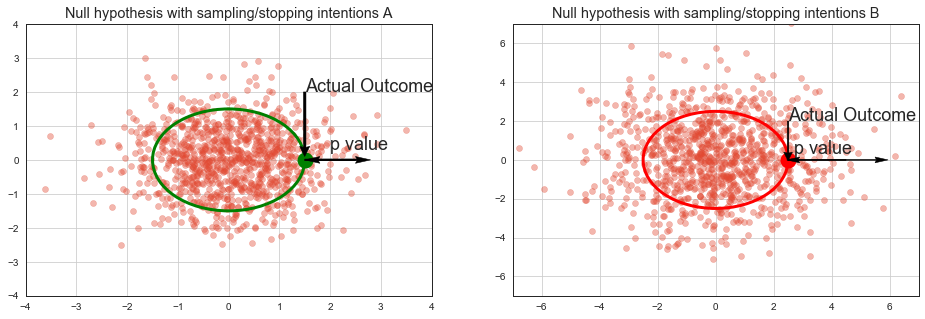

In [67]:
# different p-values
import scipy.stats as st

x1 = st.norm.rvs(size=1000)
y1 = st.norm.rvs(size=1000)

x2 = st.norm.rvs(scale=2, size=1000)
y2 = st.norm.rvs(scale=2, size=1000)

fig, axx = plt.subplots(nrows=1, ncols=2, figsize=(16, 5));
ax = axx[0]
ax.scatter(x1, y1, marker='o', alpha=.4);
ax.scatter([1.5], [0], marker='o', color='g', lw=10)
c = plt.Circle((0, 0), radius=1.5, color='g', fill=False, lw=3);
ax.add_artist(c);
ax.arrow(1.5, 0., 1.0, 0., width=.05, head_width=.2, overhang=0.1, color='k');
ax.arrow(2.5, 0., -0.7, 0., width=.05, head_width=.2, overhang=0.1, color='k', shape='full');
ax.arrow(1.5, 2., 0, -1.6, width=.05, head_width=.2, overhang=0.1, color='k', shape='full');
ax.text(2, .3, 'p value', fontsize=18);
ax.text(1.5, 2, 'Actual Outcome', fontsize=18);
ax.set_xlim((-4, 4));
ax.set_ylim((-4, 4));
ax.set_title('Null hypothesis with sampling/stopping intentions A');
ax.grid()

ax = axx[1]
ax.scatter(x2, y2, marker='o', alpha=.4);
ax.scatter([2.5], [0], marker='o', color='r', lw=10)
c = plt.Circle((0, 0), radius=2.5, color='r', fill=False, lw=3);
ax.add_artist(c);
ax.arrow(2.5, 0., 3., 0., width=.05, head_width=.3, overhang=0.1, color='k', shape='full');
ax.arrow(4.5, 0., -1.6, 0., width=.05, head_width=.3, overhang=0.1, color='k', shape='full');
ax.arrow(2.5, 2., 0, -1.6, width=.05, head_width=.3, overhang=0.1, color='k', shape='full');
ax.text(2.5, 2, 'Actual Outcome', fontsize=18);
ax.text(2.7, .3, 'p value', fontsize=18);
ax.set_xlim((-7, 7));
ax.set_ylim((-7, 7));
ax.set_title('Null hypothesis with sampling/stopping intentions B');
ax.grid()

## p-Value Depends on How we Perform the Test

Test if a coin is a fair coin ($\theta = \frac{1}{2}$) or not given a sample consisting of $N$ tosses with $z$ heads.

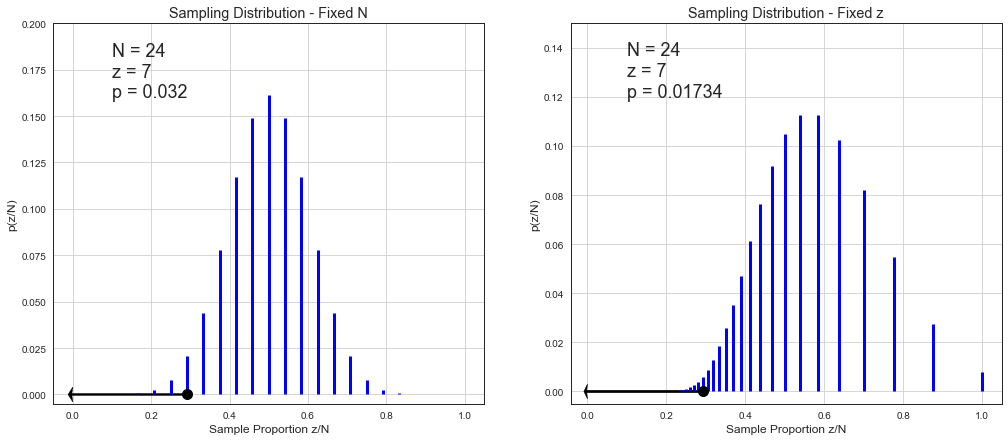

In [12]:
# simulation
z = 7
N = 24
theta = 0.5
b = st.binom(N, theta)
zs = np.arange(0., N + 1)
ns = np.arange(z, 1000.)

proba_n = b.pmf(zs)
left_tail_n = np.sum(b.pmf(zs[zs <= 7]))

proba_z = z/ns * st.binom.pmf(z, ns, theta)
left_tail_z = 1 - np.sum(z / ns[ns < N] * st.binom.pmf(z, ns[ns < N], theta))

fig, axx = plt.subplots(nrows=1, ncols=2, figsize=(17, 7));
ax = axx[0]
ax.vlines(zs/N, 0, proba_n, colors='b', linestyles='-', lw=3);
ax.plot([float(z)/N], [0.], marker='o', color='k', markersize=10);
ax.text(.1, .16, 'N = %0.0f\nz = %0.0f\np = %0.3f' % (N, z, left_tail_n), fontsize=18)
ax.set_ylim((-0.005, 0.2));
ax.set_xlabel('Sample Proportion z/N');
ax.set_ylabel('p(z/N)');
ax.grid();
ax.set_title('Sampling Distribution - Fixed N');
ax.arrow(float(z)/N, 0., -float(z)/N, 0., width=.001, head_width=.008, overhang=0.2, color='k');

ax = axx[1]
ax.vlines(z/ns, 0, proba_z, colors='b', linestyles='-', lw=3);
ax.plot([float(z)/N], [0.], marker='o', color='k', markersize=10);
plt.text(.1, .12, 'N = %0.0f\nz = %0.0f\np = %0.5f' % (N, z, left_tail_z), fontsize=18)
ax.set_ylim((-0.005, 0.15));
ax.set_xlabel('Sample Proportion z/N');
ax.set_ylabel('p(z/N)');
ax.grid()
ax.set_title('Sampling Distribution - Fixed z');
ax.arrow(float(z)/N, 0., -float(z)/N, 0., width=.001, head_width=.006, overhang=0.2, color='k');

## Quiz

You've run an A/B test. Your A/B testing software has given you a p-value of $0.03$. Which of the following is true? (Several or none of the statements may be correct.)

1. You have disproved the null hypothesis (that is, there is no difference between the variations).
1. The probability of the null hypothesis being true is 0.03.
1. You have proved your experimental hypothesis (that the variation is better than the control).
1. The probability of the variation being better than control is 97%.

[Chris Stucchio](https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#7)

All above statements are wrong!

## NHST Pros

1. Simplicity.
2. Binary thinking.
3. Studied well, tools and knowledge available.

## NHST Cons

1. Sad faces of experimenters when p-value >= 5% and we don't know if $H_0$ or $H_1$ is valid (this happens 90% of times!).
1. Needs statisticians to explain and overcome many misleading pitfalls when not running 100% correctly.
1. Unintuitive reasoning based on sampling distributions.

# Bayesian Analysis

Bayesian analysis solves all our cons of NHST.

## How Do We Update Our Belief in Things?

1. We assume our own belief for an event to happen (eg. someone gets sick) from colloquial/anecdotal knowledge.
1. When we have more evidence pointing toward (away from) the event, we increase (decrease) our beliefe for an event to happen.

<center><i>Probability that an event has happened given a set of evidence for it <br />is equal to the probability of the evidence being caused by the event multiplied by the probability of the event itself.</i></center>

$$P(\text{patient has disease given positive test result)}$$

$$\text{"is"}$$

$$P(\text{test result given patient has disease}) \times P(\text{disease})$$

$$P(d\,|\,t)\ \text{"is"}\ P(t\,|\,d) \times P(d)$$

## Example 

1. Patient has tested positive for disease $d$.
2. The test used has hit rate (recall) of 99% - probability of testing positive $t$ given patient has a disease.
3. The test used has false alarm rate (fpr) of 5% - probability of testing positive $t$ given patient does not have a disease.
4. The disease is rare striking only 1 out of 1,000 people.

What do you think is the probability of the patient having the disease when his test was positive?

## Example 

1. Patient has tested positive for disease $d$.
2. The test used has accuracy of 99% - probability of testing positive $t$ given patient has disease $d$
3. The test used has false alarm rate of 5% - probability of testing positive $t$ given patient does not have a disease.
4. The disease is rare striking only 1 out of 1,000 people.

The probability that the patient actually has the disease (given he has tested positive) is:

$$ P(d\,|\,t) = \frac{P(t\,|\,d) \times P(d)}{P(t)} $$

$$ P(d\,|\,t) = \frac{P(t\,|\,d) \times P(d)}{P(t)} $$

1. $P(t\,|\,d) = 0.99$
1. $P(d) = 0.001$
1. $P(t)$ overall probability of test returning a positive value is $P(t) = P(t\,|\,d)\,P(d) + P(t\,|\,\neg d)\,P(\neg d) = 0.05$
1. $P(t\,|\,\neg d) = 0.05$

$$ P(d\,|\,t) = \frac{0.99 \cdot 0.001}{0.99 \cdot 0.001 + 0.05 \cdot (1-0.001)} = 0.019 $$

## Different (Better) Setting?

But the patient went to see a doctor, the prior of 1 out of 10,000 is not a reality. Doctor's data show that 1 patient has the disease out of 100 of those who enter the office.

$$ P(d\,|\,t) = \frac{0.99 \times 0.01}{0.05} = 0.198 $$

## Bayesian Inference

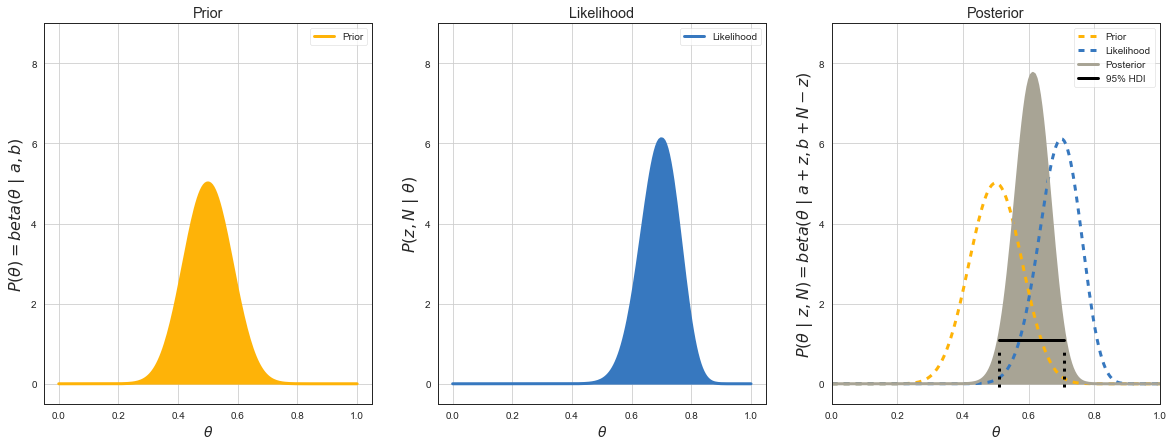

In [19]:
# prior, likelihood, posterior
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pink", "brown", "red", "light blue", "green"]
colors = sns.xkcd_palette(colors)

N = 50
z = 35
theta = z/N
rv = st.binom(N, theta)
mu = rv.mean()

a, b = 20, 20
prior = st.beta(a, b)
post = st.beta(z+a, N-z+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(20, 7))

plt.subplot(131)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c=colors[1], lw=3)
plt.fill_between(thetas, 0, prior.pdf(thetas), color=colors[1]);
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$P(\theta) = beta(\theta\ |\ a, b)$', fontsize=16)
plt.legend();
plt.grid()
plt.ylim((-0.5, 9));
plt.title('Prior');

plt.subplot(132)
plt.plot(thetas, N*st.binom(N, thetas).pmf(z), label='Likelihood', c=colors[0], lw=3)
plt.fill_between(thetas, N*st.binom(N, thetas).pmf(z), color=colors[0]);
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$P(z,N\ |\ \theta)$', fontsize=16)
plt.legend();
plt.grid()
plt.ylim((-0.5, 9));
plt.title('Likelihood');

plt.subplot(133)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c=colors[1], lw=3, dashes=[2, 2])
plt.plot(thetas, N*st.binom(N, thetas).pmf(z), label='Likelihood', c=colors[0], lw=3,dashes=[2, 2])
plt.plot(thetas, post.pdf(thetas), label='Posterior', c=colors[2], lw=3)
plt.fill_between(thetas, 0, post.pdf(thetas), color=colors[2]);
# plt.axvline((z+a-1)/(N+a+b-2), c=colors[2], linestyle='dashed', alpha=0.8, label='MAP', lw=3)
# plt.axvline(mu/N, c=colors[0], linestyle='dashed', alpha=0.8, label='MLE', lw=3)
plt.xlim((0, 1));
plt.ylim((-0.5, 11));
plt.axhline(post.pdf(ci[0]), ci[0], ci[1], c='black', label='95% HDI', lw=3);
plt.axvline(ci[0], 0.5/11.5, (post.pdf(ci[0])+0.5)/11.5, c='black', linestyle='dotted', lw=3);
plt.axvline(ci[1], 0.5/11.5, (post.pdf(ci[0])+0.5)/11.5, c='black', linestyle='dotted', lw=3);
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$P(\theta\ |\ z,N) = beta(\theta\ |\ a+z, b+N-z)$', fontsize=16)
plt.legend();
plt.ylim((-0.5, 9));
plt.grid()
plt.title('Posterior');


## Bayes Rule 

$$ P(\theta\,|\,D) = \frac{P(D\,|\,\theta)\times P(\theta)}{P(D)} $$

where $\theta$ is our estimation (eg. CTR), $D$ data we measured ($z$ heads from $N$ tosses).

$$ \text{Posterior} = \frac{\text{Likelihood} \times \text{Prior}}{\text{Total Evidence}} $$

## Impact of Prior to Posterior

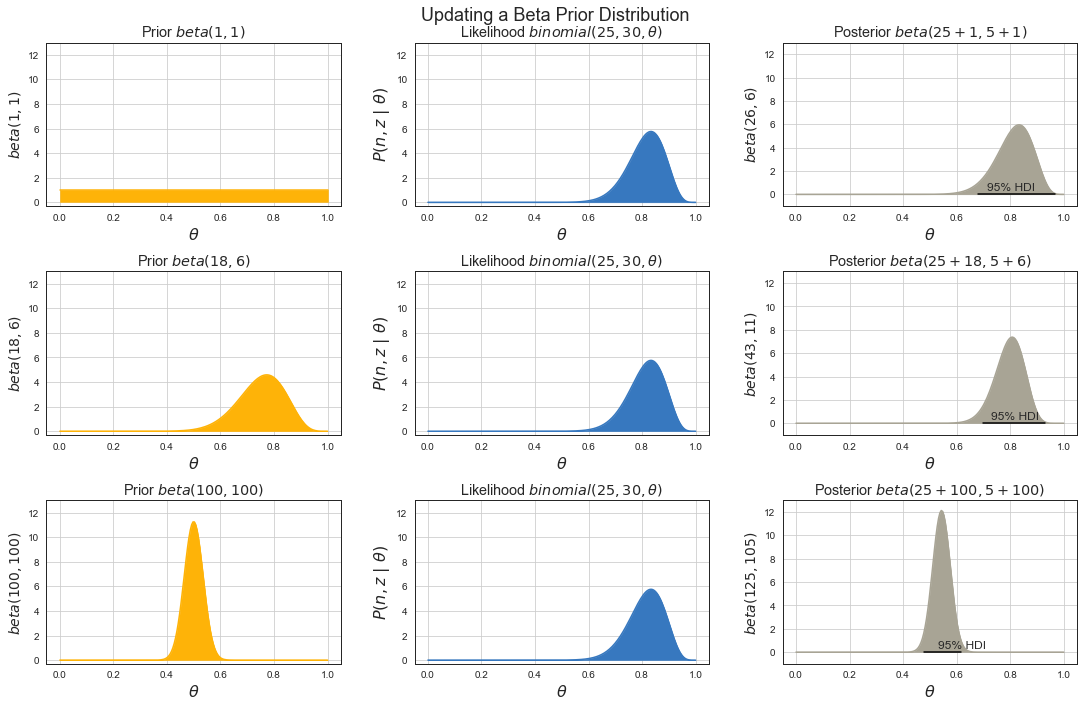

In [22]:
# prior to posterior
N = 30
z = 25
theta = z/N
rv = st.binom(N, theta)
thetas = np.linspace(0, 1, 200)

fig, axx = plt.subplots(nrows=3, ncols=3, figsize=(15, 10));
fig.suptitle('Updating a Beta Prior Distribution', fontsize=18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.4, wspace=0.25)
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pink", "brown", "red", "light blue", "green"]
colors = sns.xkcd_palette(colors)

def plot_column(a, b, z, N, thetas, axx, y_lim_top=13):
    prior = st.beta(a, b)
    post = st.beta(z+a, N-z+b)
    ci = post.interval(0.95)

    ax = axx[0]
    ax.plot(thetas, prior.pdf(thetas), c=colors[1]);
    ax.set_xlabel(r'$\theta$', fontsize=16);
    ax.set_ylabel(r'$beta(%d, %d)$' % (a, b), fontsize=14);
    ax.set_title(r'Prior $beta(%d, %d)$' % (a, b));
    ax.set_ylim(bottom=-0.3);
    ax.grid()
    if y_lim_top is not None:
        ax.set_ylim(top=y_lim_top);
    ax.fill_between(thetas, 0, prior.pdf(thetas), color=colors[1]);
    
    ax = axx[1]
    pmf = N*st.binom(N, thetas).pmf(z)
    ax.plot(thetas, pmf, label='Likelihood', c=colors[0]);
    ax.set_xlabel(r'$\theta$', fontsize=16);
    ax.set_ylabel(r'$P(n,z\ |\ \theta)$', fontsize=16);
    ax.set_title(r'Likelihood $binomial(%d, %d, \theta)$' % (z, N));
    ax.set_ylim(bottom=-0.3);
    if y_lim_top is not None:
        ax.set_ylim(top=y_lim_top);
    ax.grid()
    ax.fill_between(thetas, 0, pmf, color=colors[0]);
    
    ax = axx[2]
    ax.plot(thetas, post.pdf(thetas), label='Posterior', color=colors[2]);
    ax.fill_between(thetas, 0, post.pdf(thetas), color=colors[2]);
    ax.axhline(0, ci[0], ci[1], c='black', label='95% CI');
#     ax.text(ci[0]-0.1, .5, '%0.3f' % ci[0], fontsize=12);
#     ax.text(ci[1], .5, '%0.3f' % ci[1], fontsize=12);
    ax.text(ci[0]+0.05, .3, '95%% HDI' % ci[0], fontsize=12);
    ax.set_xlabel(r'$\theta$', fontsize=16);
    ax.set_ylabel(r'$beta(%d, %d)$' % (z+a, N-z+b), fontsize=14);
    ax.set_title(r'Posterior $beta(%d + %d, %d + %d)$' % (z, a, N-z, b));
    ax.set_ylim(bottom=-1);
    ax.grid()    
    if y_lim_top is not None:
        ax.set_ylim(top=y_lim_top);

plot_column(1, 1, z, N, thetas, axx[:][0])
plot_column(18, 6, z, N, thetas, axx[:][1])
plot_column(100, 100, z, N, thetas, axx[:][2])

## Bayes Rule for Conversions

1. Estimate conversion rate $\theta$ from $N$ impressions of an online ad that recorded $z$ clicks.
2. Or estimate the bias $\theta$ of a coin given a sample consisting of $N$ tosses with $z$ heads. 

$$P(\theta\,|\,z, N) = \frac{P(z, N\,|\,\theta)\ \text{beta}(a, b)}{P(z, N)} = \text{beta}(a+z, b+N-z)$$

Where

* $P(z, N\,|\,\theta) = P(z, N\,|\,\theta) = \binom{N}{z}\theta^z(1-\theta)^{N-z}$ is binomial likelihood function of getting test results for different $\theta$.
* $P(\theta) = beta(\theta\,|\,a, b)$ is our prior belief about where $\theta$ is before running experiment.
* $P(\theta\,|\,z,N)$ is posterior distribution aka our prior believe updated by the evidence from the experiment results of $z/N$ of where we can expect $\theta$ to lie.
* $P(\theta\,|\,z,N) = \text{beta}(\theta\,|\,a + z, b + N - z)$

$$P(\theta\,|\,z, N) = \text{beta}(a+z, b+N-z)$$

Where

* $\text{beta}$ is beta distribution
* $a$ is prior number of successes
* $b$ is prior number of failures
* $N$ number of observations in the test
* $z$ number of successes (conversions) in the test

### Beta Distribution

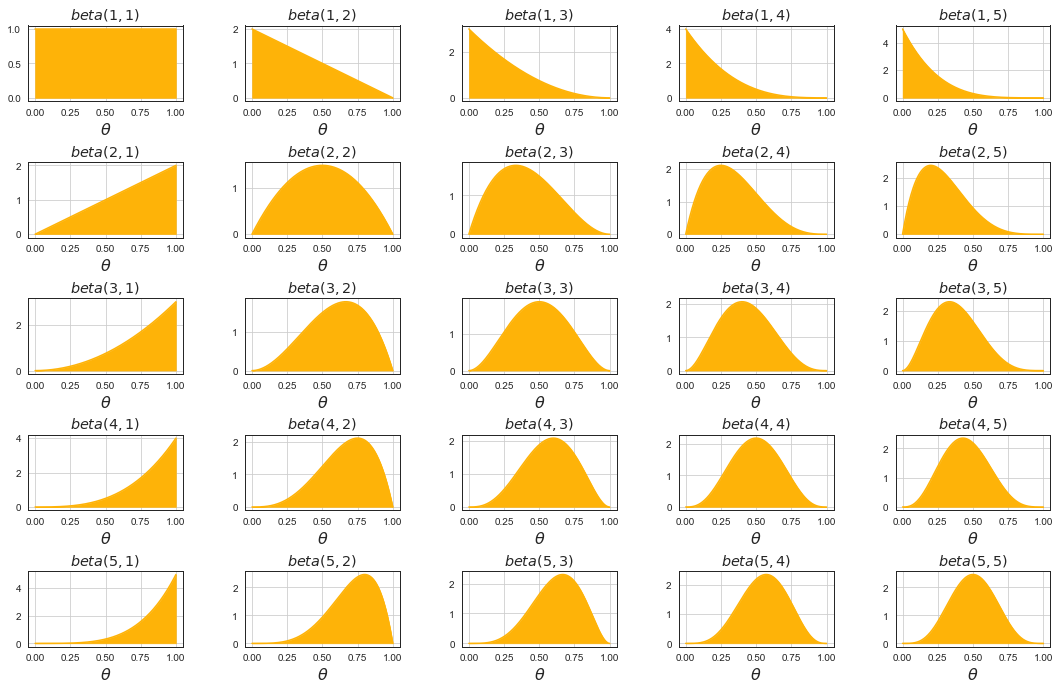

In [8]:
# beta distributions
plots = 5
thetas = np.linspace(0, 1, 200)

fig, axx = plt.subplots(nrows=plots, ncols=plots, figsize=(15, 10));
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.8, wspace=0.4)
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pink", "brown", "red", "light blue", "green"]
colors = sns.xkcd_palette(colors)

for a in range(plots):
    for b in range(plots):
        aa = a+1
        bb = b+1
        beta = st.beta(aa, bb)
        ax = axx[a][b]
        pst = beta.pdf(thetas)
        ax.plot(thetas, pst, c=colors[1])
        ax.fill_between(thetas, 0, pst, color=colors[1]);
        ax.set_xlabel(r'$\theta$', fontsize=16);
#         ax.set_ylabel(r'$p(\theta|a=%d, b=%d)$' % (aa, bb), fontsize=14);
        ax.set_title(r'$beta(%d, %d)$' % (aa, bb));
        ax.grid()

## Is Bayesian Analysis More Informative?

1. NHST does not work with priors while BA makes them explicit and part of the reasoning process.
1. NHST uses sampling distribution for inference while BA uses posterior distribution.
    * Sampling distribution tells us probabilities of possible data given a particular (null) hypothesis.
    * Posterior distribution tells us credibilities of possible hypothesis (values of $\theta$) given the data.

Good discussion of these properties from frequentists point of view could be found in:

1. [G. Georgiev, The Google Optimize Statistical Engine and Approach](http://blog.analytics-toolkit.com/2018/google-optimize-statistical-significance-statistical-engine/)
2. [G. Georgiev, 5 Reasons to Go Bayesian in AB Testing – Debunked](http://blog.analytics-toolkit.com/2017/5-reasons-bayesian-ab-testing-debunked/)

<a id='decision'></a>
# Decision Rules

1. NHST - Reject null hypothesis if p-value $\lt 5\%$.
1. Bayes
    * Reject null hypothesis if 95% HDI is outside of *Region of Practical Equivalence (ROPE)* defined around null value.
    * Accept null hypothesis if 95% HDI is completely inside of Region of Practical Equivalence.

## Decision Rules and False Positives

NHST has 100% false positive rate when doing sequentional testing stopped when p-value is below 5% with enough patience. Reasons:

1. NHST only rejects null hypothesis (cannot accept one).
1. There is non zero probability to get long stretch of extreme values that move p-value below 5%.

## Simulation of Decision Making

There are simulated data of 2000 flips with p-value calculated after every flip below. The first set is for case when null hypothesis of $\theta = 0.5$ is true. The second set is for case when null hypothesis is not true.

Graph with *$z/N$* shows proportion of $z$ in $N$ flips after every flip. Graph with p-value shows p-value calculated for cumulated data after every flip. 

Graph with 95% HDI shows 95% HDI intervals after every flip as vertical line. Decision rule based on accepting null hypothesis when 95% HDI interval is completely within ROPE (dashed lines for $\theta = 0.45$ and $\theta = 0.55$) is much stable than NHST decision rule although it has some false positives when not enough data are available.

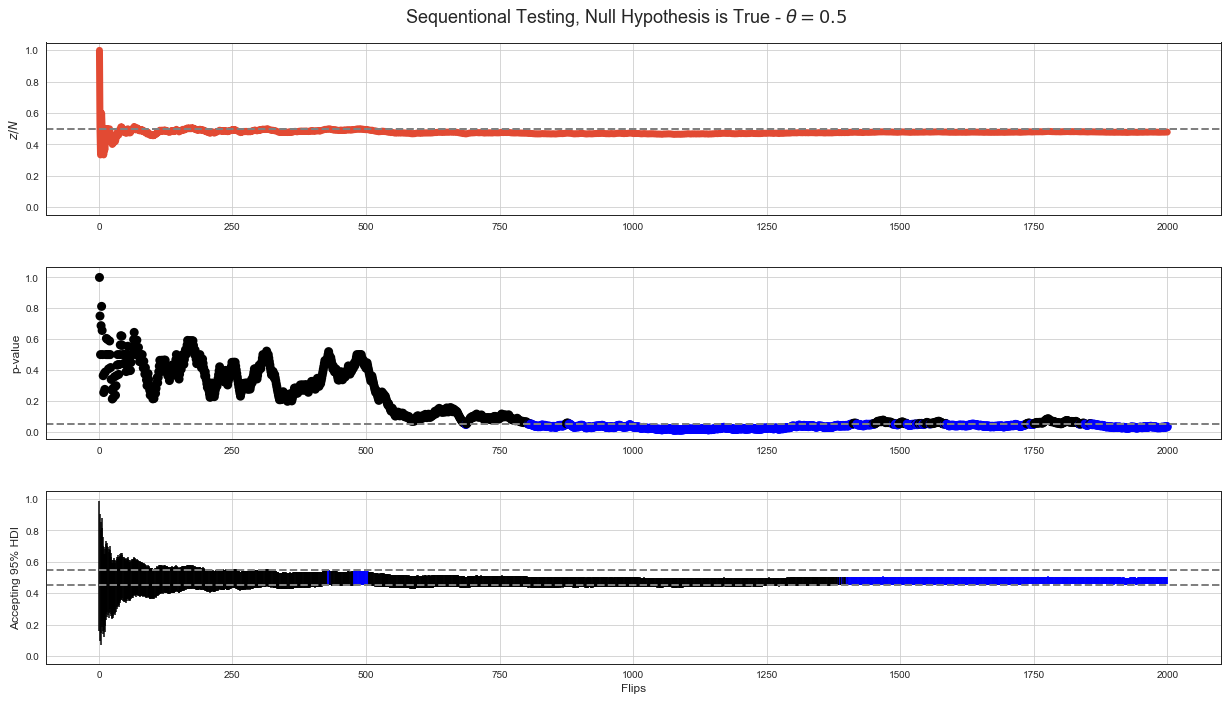

In [273]:
# null hypothesis is true
theta = 0.5
N = 2000
ns = np.arange(1, N+1)
zs = np.array(st.bernoulli.rvs(theta, size=N))
zs = np.cumsum(zs)
# np.save('zs_nh_true.npy', zs, allow_pickle=False, fix_imports=False)
zs = np.load('./imlp3_files/zs_nh_true.npy')

theta = 0.5
p_values = [np.sum(st.binom(n, theta).pmf(np.arange(0, zs[n-1] + 1))) for n in ns]
posts = st.beta(1 + zs, 1 + ns - zs)
cs = posts.interval(.95)
fig, axx = plt.subplots(nrows=3, ncols=1, figsize=(17, 10));
fig.suptitle(r'Sequentional Testing, Null Hypothesis is True - $\theta = 0.5$', fontsize=18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.3, wspace=0.25)
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pink", "brown", "red", "light blue", "green"]
colors = sns.xkcd_palette(colors)

ax = axx[0]
ax.plot(ns, zs/ns, lw=7);
ax.axhline(0.5, ls='dashed', c='gray', lw=2)
ax.grid()
ax.set_ylabel(r'$z/N$')
ax.set_ylim((-0.05, 1.05))

ax = axx[1]
ax.scatter(ns, p_values, c=['b' if p_values[n] < 0.05 else 'k' for n in range(0, N)], lw=3);
ax.axhline(0.05, ls='dashed', c='gray', lw=2)
ax.grid()
ax.set_ylabel('p-value')
ax.set_ylim(bottom=-0.05)

ax = axx[2]
ax.vlines(ns, cs[0], cs[1], colors=['b' if cs[0][n] >= 0.45 and cs[1][n] <= 0.55 else 'k' for n in range(0, N)], linestyles='-')
ax.axhline(0.45, ls='dashed', c='gray', lw=2)
ax.axhline(0.55, ls='dashed', c='gray', lw=2)
ax.grid()
ax.set_ylim((-0.05, 1.05))
ax.set_ylabel('Accepting 95% HDI')
ax.set_xlabel('Flips');

### Null Hypothesis is True

1. p-value < 5% based decision rule shows long stretches of p-value < 5% when if we stopped the test there, it would falsly reject null hypothesis. This example shows that even around flip 2000 it would falsly reject true null hypothesis.
2. 95% HDI decision rule shows much stable behavior starting fairy stably accepting true null hypothesis around step 1300.

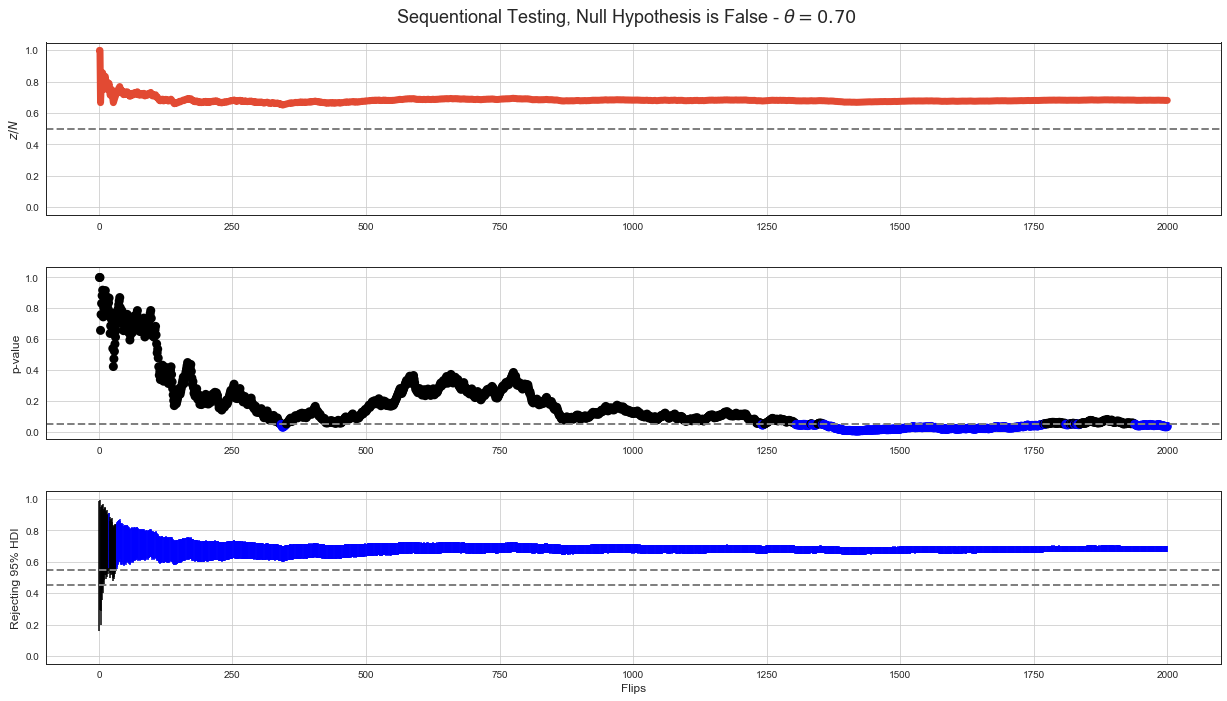

In [274]:
# null hypothesis is false
theta = 0.7
zs1 = np.array(st.bernoulli.rvs(theta, size=N))
zs1 = np.cumsum(zs1)
# np.save('zsa.npy', zs1, allow_pickle=False, fix_imports=False)
zs1 = np.load('./imlp3_files/zs_null_false.npy')

theta = 0.7
p_values = [np.sum(st.binom(n, theta).pmf(np.arange(0, zs1[n-1] + 1))) for n in ns]
posts = st.beta(1 + zs1, 1 + ns - zs1)
cs = posts.interval(.95)

fig, axx = plt.subplots(nrows=3, ncols=1, figsize=(17, 10));
fig.suptitle(r'Sequentional Testing, Null Hypothesis is False - $\theta = %0.2f$' % theta, fontsize=18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.3, wspace=0.25)
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pink", "brown", "red", "light blue", "green"]
colors = sns.xkcd_palette(colors)

ax = axx[0]
ax.plot(ns, zs1/ns, lw=7);
ax.axhline(0.5, ls='dashed', c='gray', lw=2)
ax.set_ylabel(r'$z/N$')
ax.grid()
ax.set_ylim((-0.05, 1.05))

ax = axx[1]
ax.scatter(ns, p_values, c=['b' if p_values[n] < 0.05 else 'k' for n in range(0, N)], lw=3);
ax.axhline(0.05, ls='dashed', c='gray', lw=2)
ax.set_ylabel('p-value')
ax.grid()
ax.set_ylim(bottom=-0.05)

ax = axx[2]
ax.vlines(ns, cs[0], cs[1], colors=['b' if cs[0][n] > 0.55 else 'k' for n in range(0, N)], linestyles='-')
ax.axhline(0.45, ls='dashed', c='gray', lw=2)
ax.axhline(0.55, ls='dashed', c='gray', lw=2)
ax.set_ylim((-0.05, 1.05))
ax.set_ylabel('Rejecting 95% HDI')
ax.grid()
ax.set_xlabel('Flips');

### Null Hypothesis is False

1. p-value < 5% based decision rule starts correctly rejecting null hypothesis after step 1300. There's also stretch around 1800 steps when it stops rejecting null hypothesis.
2. 95% HDI decision rule starts rejecting null hypothesis much sooner and shows stable behavior.

<a id="pbb"></a>
# Probabilistic Results

We measure experiment results (conversion rates) and calculate their posterior distributions. We sample many (>= 1,000,000) samples from these posterior distributions and calculate following properties of these samples per variant.

1. Improvement
2. Probability to Beat Baseline
3. Probability to Be the Best

In [17]:
N = 10000 # samples per variant in experiment
S = 10000 # number of samples taken from posterior distribution

theta_a = 0.1  # simulated conversion rates of three variants
theta_b = 0.11
theta_c = 0.12

ns = np.arange(1, N+1)

zs_a = np.cumsum(np.array(st.bernoulli.rvs(theta_a, size=N))) # cumulated number of conversion
zs_b = np.cumsum(np.array(st.bernoulli.rvs(theta_b, size=N)))
zs_c = np.cumsum(np.array(st.bernoulli.rvs(theta_c, size=N)))

posts_a = st.beta(1 + zs_a, 1 + ns - zs_a) # for each measurement, take its beta distribution, we have N betas per variant
posts_b = st.beta(1 + zs_b, 1 + ns - zs_b)
posts_c = st.beta(1 + zs_c, 1 + ns - zs_c)

posts_a_rvs = posts_a.rvs(size=(S, N)) # sample S samples from each of N betas
posts_b_rvs = posts_b.rvs(size=(S, N))
posts_c_rvs = posts_c.rvs(size=(S, N))

improvement = np.median(((posts_c_rvs - posts_a_rvs) / posts_a_rvs), axis=0)
beat_baseline = np.sum(np.where(posts_c_rvs > posts_a_rvs, 1, 0), axis=0) / S

pbb = np.argmax(np.array((posts_a_rvs, posts_b_rvs, posts_c_rvs)), axis=0) # who won in 3x S samples in every N samples
pbb_a = np.sum(np.where(pbb == 0, 1, 0), axis=0) / S
pbb_b = np.sum(np.where(pbb == 1, 1, 0), axis=0) / S
pbb_c = np.sum(np.where(pbb == 2, 1, 0), axis=0) / S

## Improvement

Median improvement that we can expect over the baseline if we full scale the variant.

$$ \text{Improvement of C over A} = \text{median}\left(\frac{\text{Sample C} - \text{Sample A}}{\text{Sample A}}\right) $$

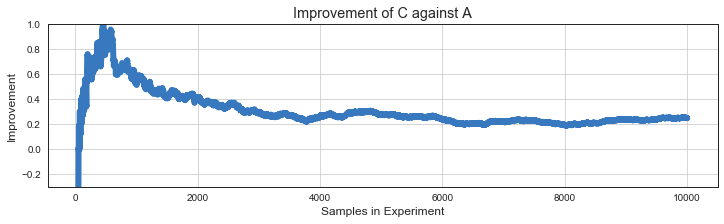

In [18]:
# improvement of C against A
f = 50
fig = plt.figure(figsize=(12, 3));
plt.plot(ns[f:], improvement[f:], lw=6, c=colors[0]);
plt.grid();
plt.title('Improvement of C against A');
plt.xlabel('Samples in Experiment');
plt.ylabel('Improvement');
plt.ylim((-.3, 1));

## Probability to Beat Baseline

Number of times treatment variant sample beats control (baseline) variant sample.

$$ \text{Probability of variant C beating A} = \frac{\text{Number of times variant C sample is greater than variant A sample}}{\text{Total number of samples}} $$

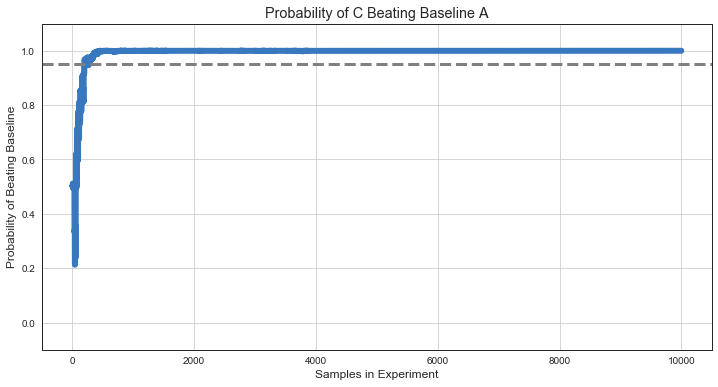

In [19]:
# probability of C beating baseline A
fig = plt.figure(figsize=(12, 6));
plt.plot(ns, beat_baseline, lw=6, c=colors[0]);
plt.axhline(0.95, ls='dashed', c='gray', lw=3)
plt.grid();
plt.ylim((-0.1, 1.1))
plt.title('Probability of C Beating Baseline A');
plt.xlabel('Samples in Experiment');
plt.ylabel('Probability of Beating Baseline');

## Probability to Be the Best

Number of times variant sample beats all other variants samples.

$$ \text{Probability of variant C being the best} = \frac{\text{Number of times variant C sample is greater than other variant samples}}{\text{Total number of samples}} $$

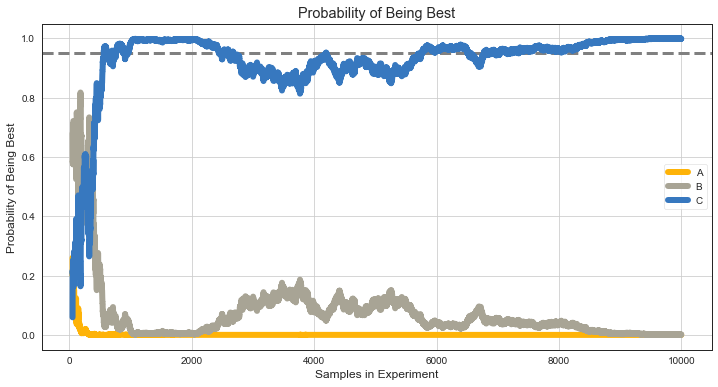

In [20]:
# probability of being best
fig = plt.figure(figsize=(12, 6));
plt.axhline(0.95, ls='dashed', c='gray', lw=3)
plt.plot(ns[f:], pbb_a[f:], lw=6, label='A', c=colors[1]);
plt.plot(ns[f:], pbb_b[f:], lw=6, label='B', c=colors[2]);
plt.plot(ns[f:], pbb_c[f:], lw=6, label='C', c=colors[0]);
plt.grid();
plt.legend();
plt.title('Probability of Being Best');
plt.xlabel('Samples in Experiment');
plt.ylabel('Probability of Being Best');

## AB Test Dashboard

![dashboard](./imlp3_files/dashboard.png)

# Lessons from Running Thousands of A/B Tests

[Ronny Kohavi](https://exp-platform.com/Documents/2014-10-11MITCodeKohaviExP.pdf)

## 1. Assessing the Value of Novel Ideas is Hard

1. Correlation of bloodletting and calming effects on patients let doctors practice it for 2000 years.
2. [Semmelweis Reflex](https://en.wikipedia.org/wiki/Semmelweis_reflex) - it is hard to subject your idea to the metric and receive negative feedback
3. Experiment often
    1. To have a great idea, have a lot of them. (Thomas Edison)
    1. If you have to kiss a lot of frogs, to find a prince, find more frogs and kiss them faster and faster. (Mike Moran, Do it Wrong Quickly)

## HiPPO

![hippo](./imlp3_files/hippo.jpg)

Jim Barksdale (former CEO of Netscape): *If we have data, let's look at data. If all we have are opinions, let's go with mine.*

# 2. OEC - Overall Evaluation Criterion

1. Agree early on
2. Optimize for long-term, something meaningful for the company as a whole
3. Examples
    1. Visits / user
    2. Revenue / user
    3. Engagement
    4. Tasks / user
    5. Successes / user
4. Report also other diagnostic metrics

# 3. We Need a Lot of Users

1. Number of users required in experiment is proportional to $\sigma^2/\Delta^2$.
1. Many key metrics have high-variance (eg. sessions/user, revenue/user).
1. The problem:
    1. As we optimize, we need to measure smaller and smaller changes.
    1. We need 100K users per variant to detect 2% change to revenue.
    1. We need 40M users to detect 0.1% change to revenue

1. We must run large experiments.
1. Use variance reduction techniques
    1. Exposing - analyze only those exposed to the test
    2. Lower-variance metrics likes conversion rates
1. Use bayesian analysis to get insights from "statistically insignificant" tests.

# 4. Getting Numbers is Easy, Trust is Hard

1. Data quality, data quality
2. A/A tests should be significant in OEC only 5% of times (just by chance).
3. Sample ratio mismatch (getting 49/51% randomization is signal of a bug).

<a id='rules'></a>
# Rules of Thumb

As described in R. Kohavi, A. Deng, R. Longbotham, Ya Xu [Seven Rules of Thumb for Website Experimenters](https://exp-platform.com/Documents/2014%20experimentersRulesOfThumb.pdf)

## Small Changes can have a Big Impact to Key Metrics

Small changes can have large negative impact (like doing a bug), we will consider small changes that have positive impact.

Very rare but happens (1 out of 500 experiments - authors cite MS Bing experiments).

## Changes Rarely have a Big Positive Impact to Key Metrics

Winning is done inch by inch. Key metrics are organizational metrics like revenue per user, sessions per user etc.

## Shifting and Canibalizing is Easy, Improving is Hard

Does shifting button to the left have impact on sessions per user? What if other team tests moving it to the right a month later. Optimizing for a click on online ad is easy, optimizing on revenue per user is hard.

## Avoid Complex Designs, Iterate

Learn quickly, test rather A/B than A/B/C/D or even multi-variate testing. It's splitting traffic, get the learnings quickly as possible. Introduce one change at the time.

## Have Enough Users

Formulas for minimum sample size given variance and sensitivity provide lower bound but assume distribution of the mean is normal. Skewed metrics require higher lower bound.

<a id='not'></a>
# Top Challenges

There's no improvement without failure. Many experiments do not improve their target metric. In big companies, numbers of experiments without measurable impact are large - Goodle 92%, Bookings.com 90%, Microsoft 66% experiments do not improve target metric.

1. Analysis
2. Engineering and culture
3. Deviation from traditional A/B tests
4. Data quality
5. S. Gupta, R. Kohavi, et al. [Top Challenges from the first Practical Online Controlled
Experiments Summit](https://exp-platform.com/Documents/2019-FirstPracticalOnlineControlledExperimentsSummit_SIGKDDExplorations.pdf)

## Analysis

Changing part of software usually takes few weeks as well as running some experiment measuring impact of the change. We run expeeriments for few weeks, measure impact but we are more interested in effect on long-term user metrics. For example changing order of search results in online holiday portal can be evaluated after several months after customers spent holidays in booked hotel.

It is not recommended to run long-term experiments as tracking is difficult, users access from different platforms, discuss with other influenced by other variants, etc. It is ok to run the test little longer if there's novelty effect or users need some time for learning.

Finding good *proxy metrics* that have signals for long-term metrics is prefered way. These proxies could be found by models eg. use logistic regression to find good predictors for life time value or survival analysis with righ-censored data to find predictors for user retention. Always beware of that correlation in short and long-term metrics does not necessarily means causation.

*Surrogate modeling* is another way to find good estimates of long-term outcome. 

## Engineering and Culture

Our intuition is a poor judge for the value of ideas. Experimentation avoids highest paid person in the room to do decisions. It takes time to transition from a point where negative experiment results feels like someone telling you that your baby is ugly. Also failed experiments with some significant impact are good for learning.

Important to pick the most important metric - designers are keen to fullscale their work, if the test fails, it is very hard to see changes and work going away. Semmelweis Reflex - it is hard to subject your idea to the metric and receive negative feedback, good hand hygiene and scrubs before visiting patient example.

There will always be some significant change in some metric, but could be caused by random, or is not that important to decision about fullscale.

Ambasadors, shepherds, peer reviews, education, education, education to the team.

Experimentation portal/social network with test definition, sampling criteria, stopping criteria, description, results.
Always plan action for 3 possible outcomes beforehead - sig. positive/negative, inconclusive.
Searchable database with test results to learn from.

## Deviation from Traditional A/B Tests

1. Violations to SUTVA - stable user treatment value to accurately analyze the treatment effect - is often violated because of user interactions in their social graphs or using shared resources (same CPU).
1. Simpson paradox (ramp up with same ratio in every group, eg. start with 5% in control and 5% in treatment and than go to 20% both and so on).
1. Novelty and primacy (old users are different from new users), segment user base and run test on one segment only or evaluate for covarietes. Common segments are geo (rather on "continent" level), activity level, device and platform, day of week, product specific segments, all categorical with only few categories.
1. Interaction between experiments - use simple linear regression to check for interaction terms. It has many false positives though. Or split traffic.
1. Do not test on Christmass and holiday seasons.

## Data Quality and Infering Results

Diagnostics - regular AA tests and check how often they have significant results should not be more often than 1 - your significance level (eg. 95%).

Subject difference in variant randomization to similar statistical test as other different metric. This could reveal hidden bugs in experimentation platform or client code.

Apply **Twyman's law**! 

![alaska](./imlp3_files/alaska.png)

Examples

1. If you have a mandatory birth date field and people think it’s unnecessary, you’ll find lots of people born on 11/11/11 or 01/01/01 
1. If you have an optional drop down, do not default to the first alphabetical entry, or you’ll have lots of: jobs = Astronaut
1. For most web sites, traffic had no traffic between 2AM and 3AM March 9, 2014. Don’t worry, there was no outage. It’s daylight saving.
1. No modern editor will celebrate a new proof of $\text{P} = \text{NP}$ against a strong prior (see below in Bayes analysis) that a correct proof is very unlikely. 
1. [Link](https://amplitude.com/blog/2017/05/17/twymans-law)

<a id='resources'></a>
# Resources

1. **Prem S. Mann** Introductory Statistics 7nd Edition
2. **R. Kohavi, A. Deng** [Seven Rules of Thumb for Website Experimenters](https://exp-platform.com/Documents/2014%20experimentersRulesOfThumb.pdf)
3. **John Kruschke** [Doing Bayesian Data Analysis](https://www.amazon.com/dp/0124058884)
4. **S. Gupta, R. Kohavi et al.** [Top Challenges from the first Practical Online Controlled Experiments Summit](https://exp-platform.com/Documents/2019-FirstPracticalOnlineControlledExperimentsSummit_SIGKDDExplorations.pdf)
5. **H. Hohnhold, D. O'Brien, D. Tang** [Focusing on the Long-term: It's Good for Users and Business](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43887.pdf)
5. [ExP Experimentation Platform](https://exp-platform.com/)
6. [Computational Statistics in Python](https://people.duke.edu/~ccc14/sta-663/MCMC.html)